In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from collections import Counter
import networkx as nx
from scipy import stats

### Reading already parsed datasets

In [2]:
NY_df = pd.read_csv('data/newyork_dataset', sep=',',low_memory=False, header=0, encoding='utf8')
CHI_df = pd.read_csv('data/chicago_dataset', sep=',',low_memory=False, header=0, encoding='utf8')
BOS_df = pd.read_csv('data/boston_dataset', sep=',',low_memory=False, header=0, encoding='utf8')

Number of station - nodes for each dataset

In [3]:
print('NY: # start stations =',(NY_df['start station name'].nunique()), '; # end stations =',(NY_df['end station name'].nunique()))
print('CHI: # start stations =',(CHI_df['start station name'].nunique()), '; # end stations =',(CHI_df['end station name'].nunique()))
print('BOS: # start stations =',(BOS_df['start station name'].nunique()), '; # end stations =',(BOS_df['end station name'].nunique()))

NY: # start stations = 784 ; # end stations = 791
CHI: # start stations = 571 ; # end stations = 569
BOS: # start stations = 268 ; # end stations = 268


### Adjacency matrices

In [4]:
def visualize_adj(adj):
    fig, ax = plt.subplots(2,2,figsize=(12,10))
    a_adj = adj.toarray()
    sns.heatmap(a_adj, cmap="Blues", ax=ax[0,0])
    a_adj[a_adj>500] = 500
    sns.heatmap(a_adj, cmap="Blues", ax=ax[0,1])
    a_adj[a_adj>100] = 100
    sns.heatmap(a_adj, cmap="Blues", ax=ax[1,0])
    a_adj[a_adj>10] = 10
    sns.heatmap(a_adj, cmap="Blues", ax=ax[1,1])
    plt.tight_layout()
    plt.show()

def adjacency(df):
    # nodes = np.array(list(pd.concat([df.loc[:, 'start station name'], df.loc[:, 'end station name']]).drop_duplicates()))
    nodes = np.array(list(set.union(set(df.loc[:, 'start station name']), set(df.loc[:, 'end station name']))))
    # df.dropna(how='any', inplace=True)
    
    node_position = {}
    for i, name in enumerate(nodes):
        node_position[name] = i
    nodes_df = pd.DataFrame({'Nodes': nodes})
    df['SendId'] = (np.array(list(map(lambda x: node_position[x], df['start station name']))))
    df['RecId']= (np.array(list(map(lambda x: node_position[x], df['end station name']))))
    
    # Adjacency matrix
    serie = df[['SendId', 'RecId', 'tripduration']].groupby(['SendId', 'RecId']).count()
    row = np.array(serie.index.get_level_values(1).tolist())
    col = np.array(serie.index.get_level_values(0).tolist())
    val = serie.values
    adj_matrix = sparse.csr_matrix((val.flatten(), (row, col)))

    visualize_adj(adj_matrix)
    
    # to see if the matrix is symmetric
    matr = adj_matrix.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()
    
    return df, adj_matrix, nodes_df, nodes

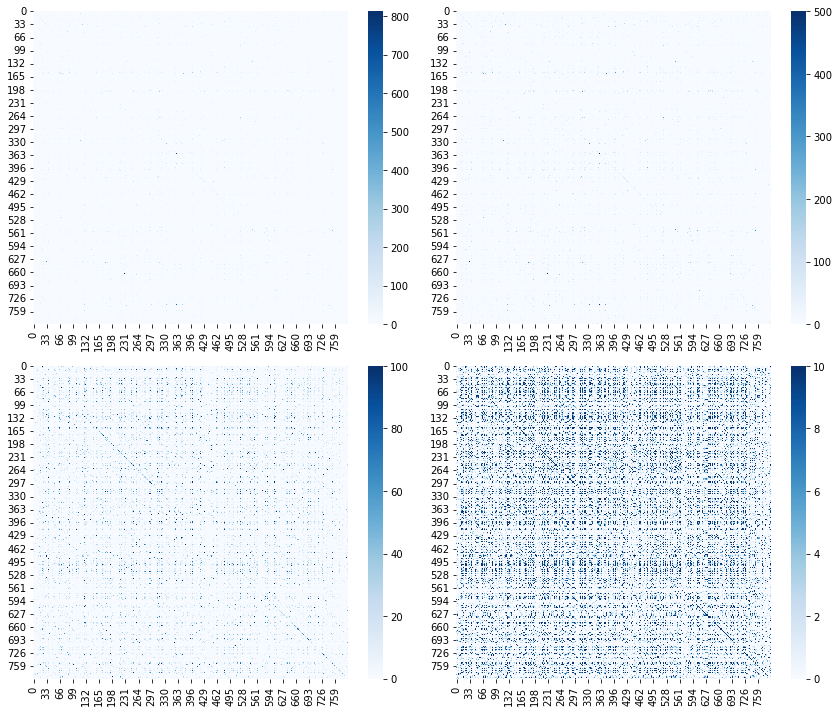

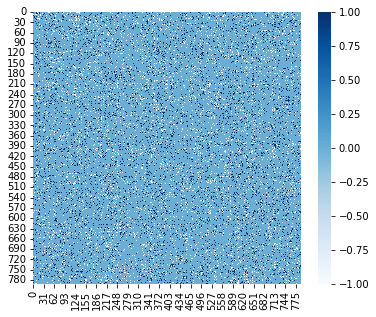

In [5]:
NY_df, NY_adj, NY_nodes_df, NY_nodes = adjacency(NY_df)

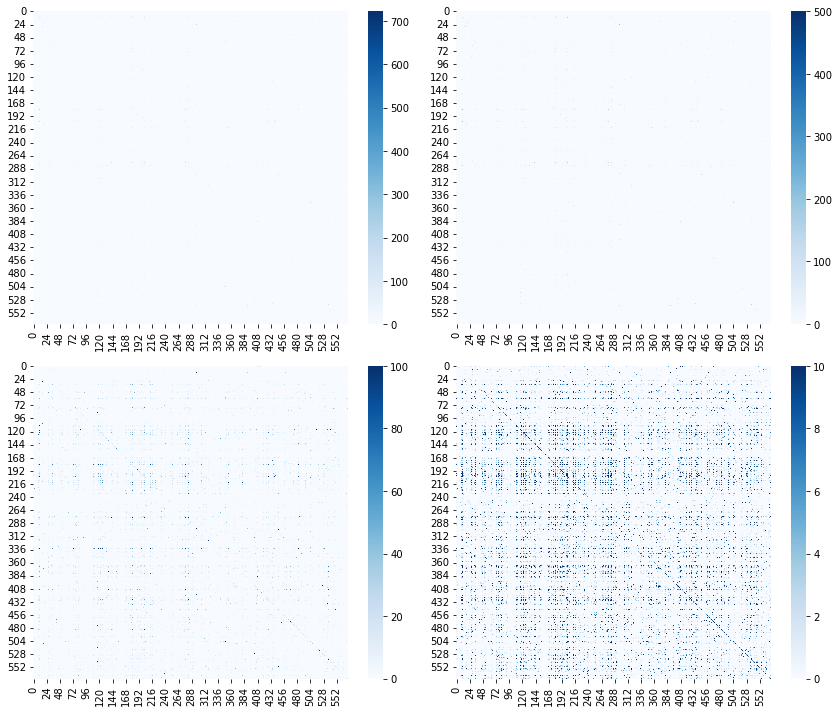

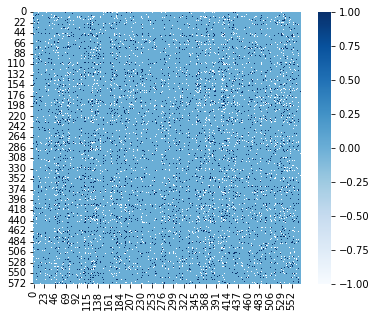

In [6]:
CHI_df, CHI_adj, CHI_nodes_df, CHI_nodes = adjacency(CHI_df)

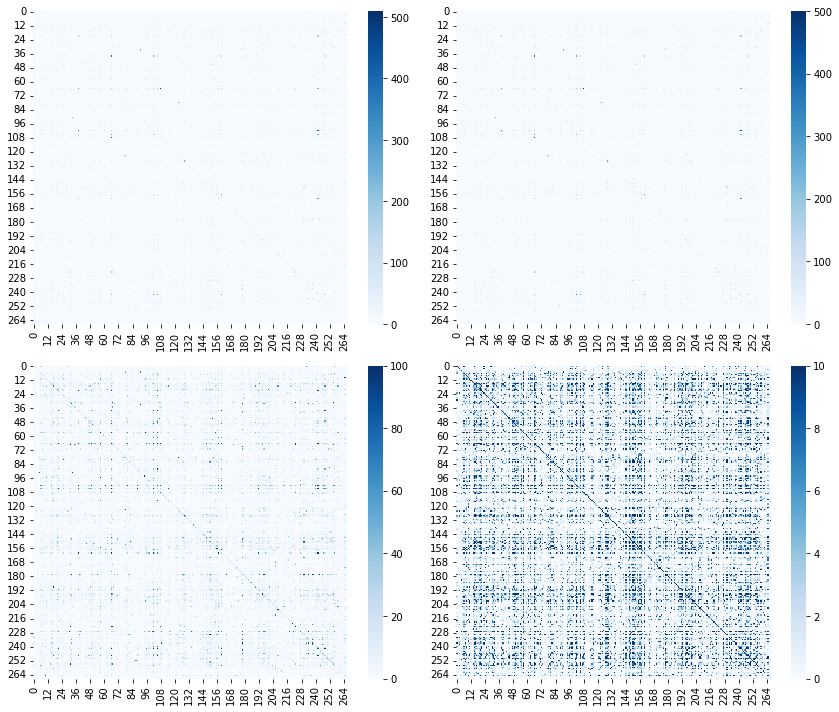

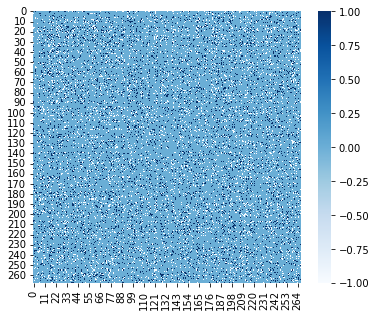

In [7]:
BOS_df, BOS_adj, BOS_nodes_df, BOS_nodes = adjacency(BOS_df)

?? Take in consideration only the giant component ??

### Degree distribution

In [8]:
def plot_probability_loglog(ax, x, y, title, cumulative=False):
    ax.loglog(x, y, 'o', markersize = 4)
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.set_title(title, size = 22)
    ax.set_xlabel("k", size = 20)
    if cumulative:
        ax.set_ylabel("P_k", size = 20)
    else:
        ax.set_ylabel("p_k", size = 20)
    ax.tick_params(labelsize=18)
    ax.tick_params(labelsize=18)

def degree_distribution(adj_matrix, nodes):
    N = len(nodes.index)
    df = nodes.copy()
    d_in = adj_matrix.dot(np.ones(N))
    d_out = (adj_matrix.T).dot(np.ones(N))
    d_in = d_in.astype(int)
    d_out = d_out.astype(int)

    df['in degree'] = d_in
    df['out degree'] = d_out
    
    d_in = d_in[d_in > 0]
    d_out = d_out[d_out > 0]

    ############# in #############
    sorted_d = sorted(d_in)
    occurrence = Counter(sorted_d)
    x_in = list(occurrence.keys())
    y_in = list(occurrence.values())
    y_in = y_in/np.sum(y_in)

    Pk_in = 1 - np.cumsum(y_in) # complementary cumulative

    # set the last value of Pk (that is equal to 0 and generates problems when plotting in the log-scale) 
    # equal to 1 and sort Pk in decreasing order to put the 1 at the beginning of the array
    Pk_in[-1] = 1 
    Pk_in = sorted(Pk_in, reverse = True)

    ############# out #############
    sorted_d = sorted(d_out)
    occurrence = Counter(sorted_d)
    x_out = list(occurrence.keys())
    y_out = list(occurrence.values())
    y_out = y_out/np.sum(y_out)

    Pk_out = 1 - np.cumsum(y_out) # complementary cumulative

    # set the last value of Pk (that is equal to 0 and generates problems when plotting in the log-scale) 
    # equal to 1 and sort Pk in decreasing order to put the 1 at the beginning of the array
    Pk_out[-1] = 1 
    Pk_out = sorted(Pk_out, reverse = True)

    # Plotting    
    fig, ax = plt.subplots(2, 2, figsize = (30, 20))
    plot_probability_loglog(ax[0,0], x_in, y_in, "IN-Degree Distribution")
    plot_probability_loglog(ax[0,1], x_in, Pk_in, "IN-CCDF", True)
    plot_probability_loglog(ax[1,0], x_out, y_out, "OUT-Degree Distribution")
    plot_probability_loglog(ax[1,1], x_out, Pk_out, "OUT-CCDF", True)
    plt.show()
    
    return df

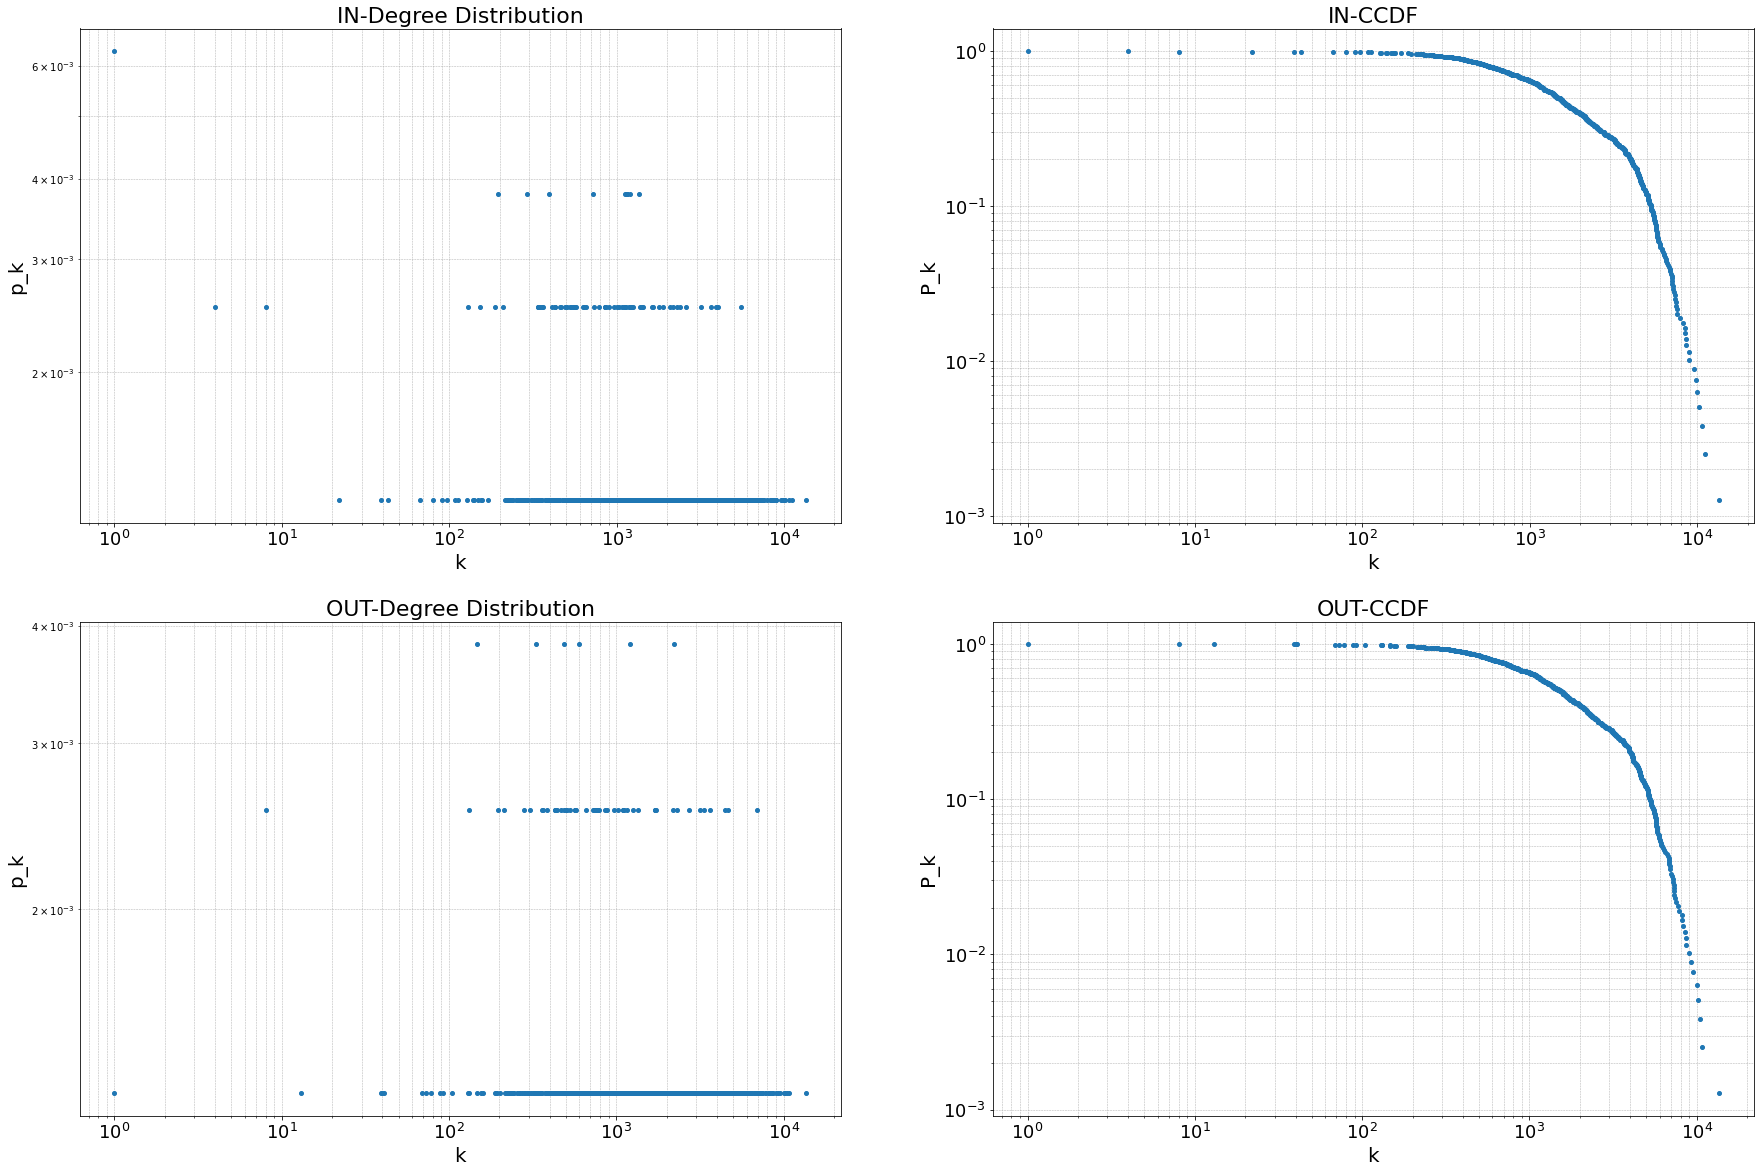

Nodes  in degree  out degree
155          Pershing Square North      13548       13625
400             Broadway & E 22 St      11117       10714
154             E 17 St & Broadway      10671       10411
520                8 Ave & W 31 St      10194       10141
606                W 21 St & 6 Ave      10025       10009
471          West St & Chambers St       9904        8996
480             Broadway & E 14 St       9594        9450
393               W 20 St & 11 Ave       8967        8609
128             Broadway & W 60 St       8926        9248
200  Christopher St & Greenwich St       8599        8565

In [9]:
NY_scores = degree_distribution(NY_adj, NY_nodes_df)
NY_scores.sort_values('in degree', ascending=False).head(10)

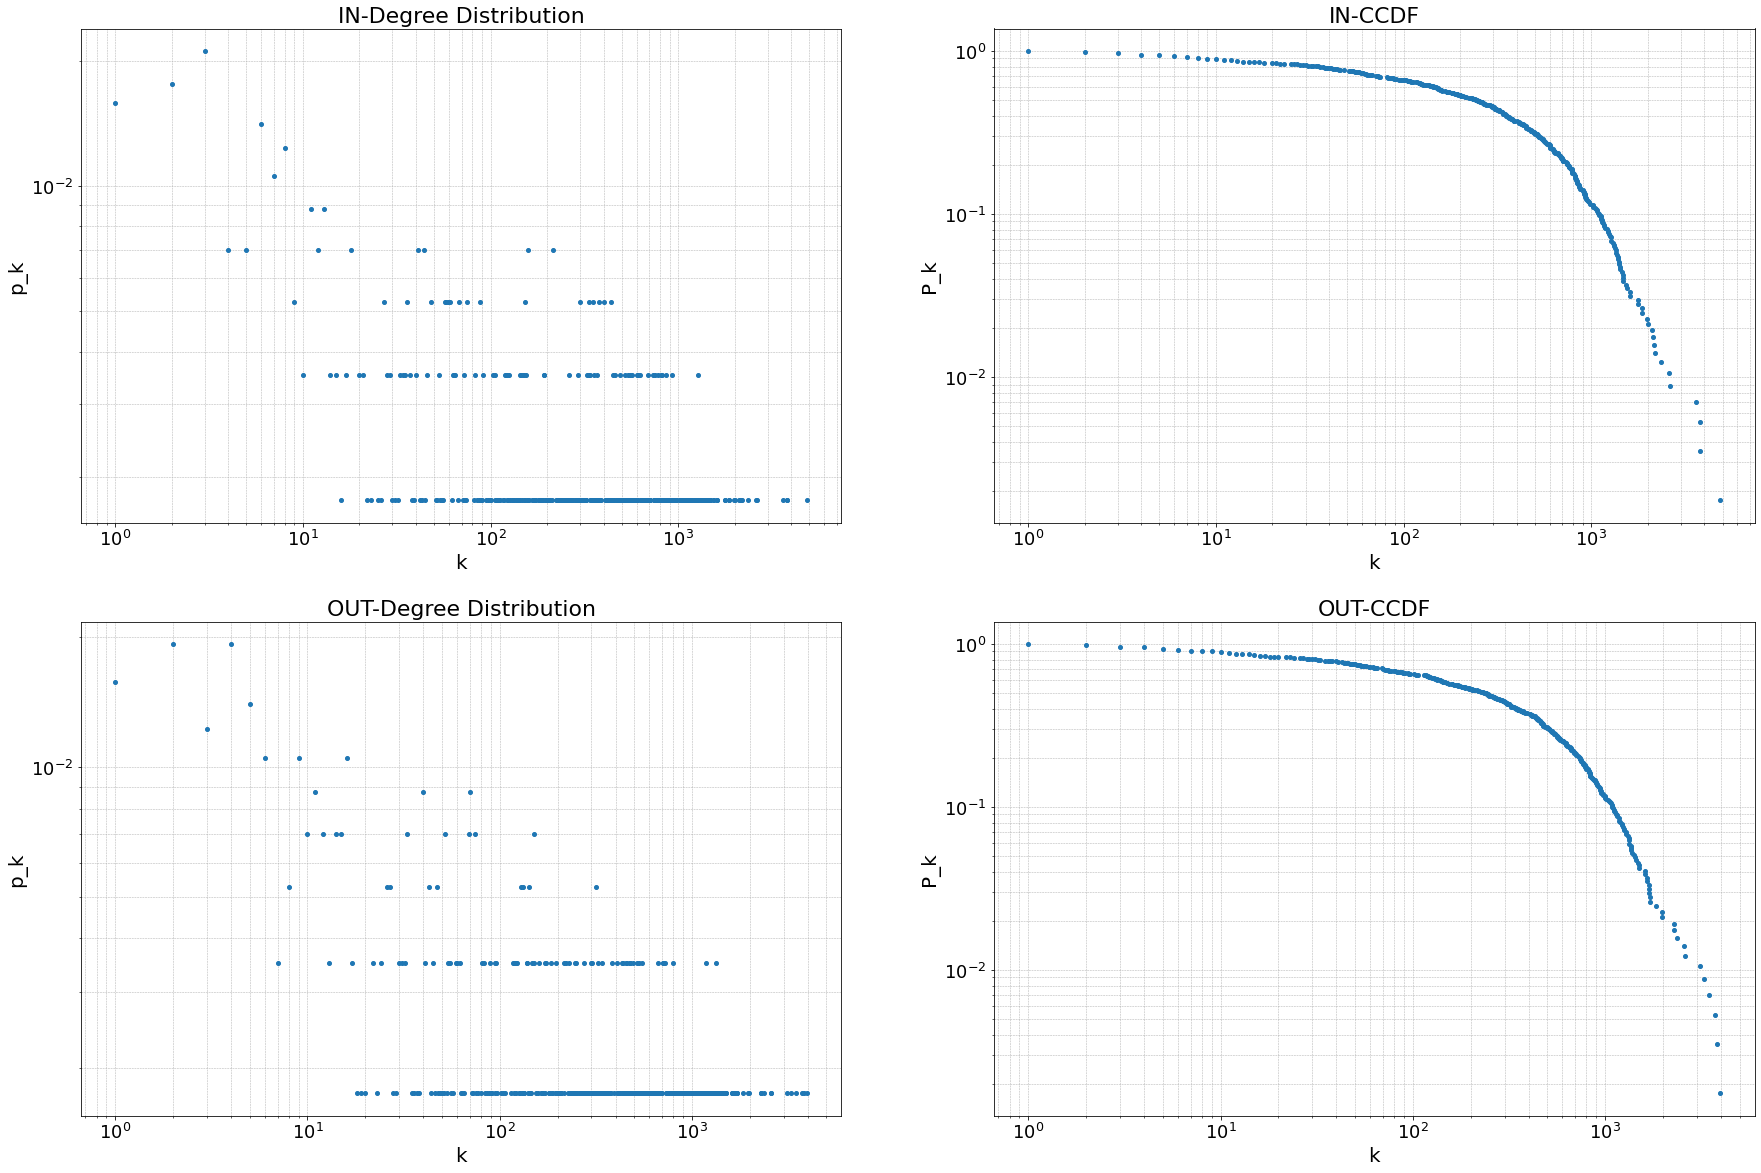

Nodes  in degree  out degree
409       Streeter Dr & Grand Ave       4844        3710
334           Canal St & Adams St       3806        3827
282       Clinton St & Madison St       3804        3477
180  Clinton St & Washington Blvd       3619        3958
376     Lake Shore Dr & Monroe St       2630        3253
277  Michigan Ave & Washington St       2584        2292
202         Canal St & Madison St       2343        2589
122            Daley Center Plaza       2186        2366
213      Kingsbury St & Kinzie St       2156        2283
121         Michigan Ave & Oak St       2126        1965

In [10]:
CHI_scores = degree_distribution(CHI_adj, CHI_nodes_df)
CHI_scores.sort_values('in degree', ascending=False).head(10)

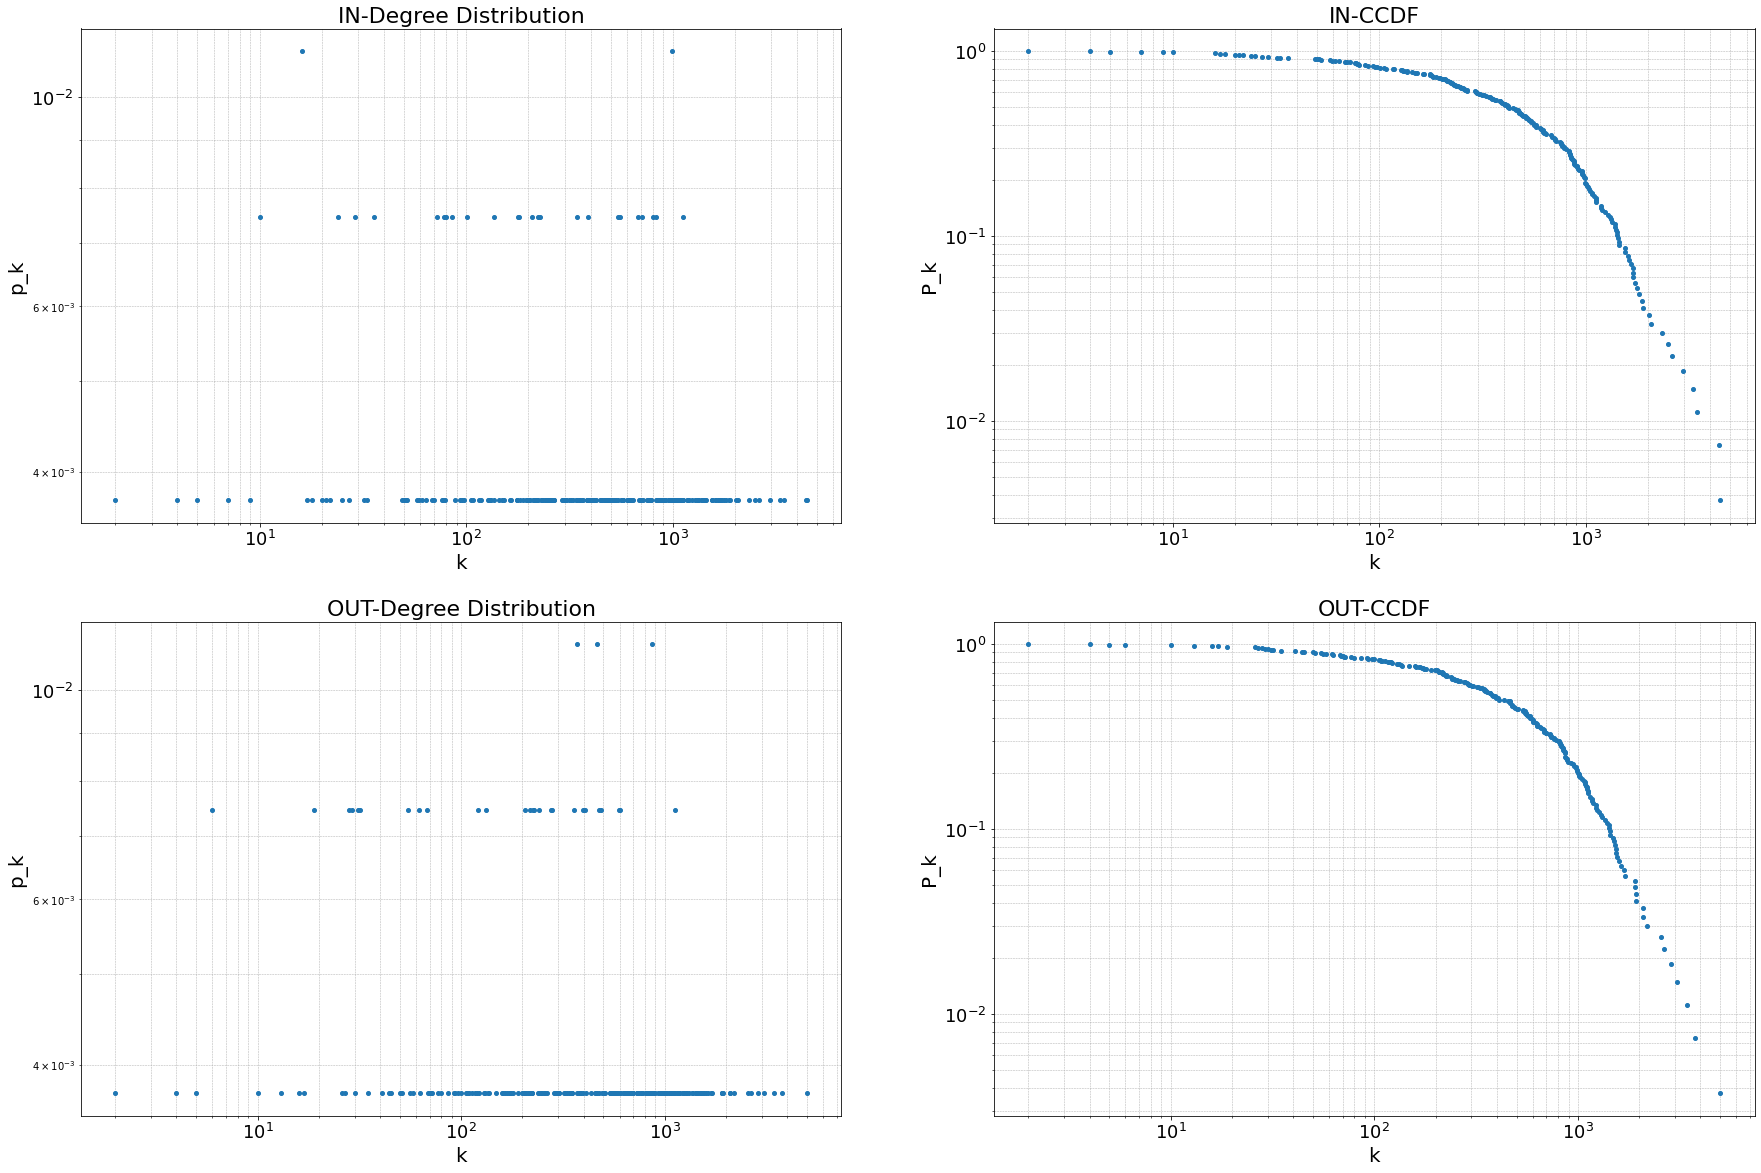

Nodes  in degree  out degree
102            MIT Stata Center at Vassar St / Main St       4463        3761
66                        MIT at Mass Ave / Amherst St       4412        4989
105              Central Square at Mass Ave / Essex St       3449        3435
227                  Nashua Street at Red Auerbach Way       3313        2086
178                   South Station - 700 Atlantic Ave       2968        2879
57                 Harvard Square at Mass Ave/ Dunster       2603        2563
160                                          Kendall T       2499        3075
242                    MIT Pacific St at Purrington St       2348        2644
147  Christian Science Plaza - Massachusetts Ave at...       2060        1916
38                                       MIT Vassar St       2030        2082

In [11]:
BOS_scores = degree_distribution(BOS_adj, BOS_nodes_df)
BOS_scores.sort_values('in degree', ascending=False).head(10)

### Hits and PageRank

In [12]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores

In [13]:
# return DataFrame containing nodes, their hub and autority score
def hits_alg(adj, nodes, score_df=None):
    hh, aa = nx.algorithms.link_analysis.hits_alg.hits(nx.DiGraph(adj.T), tol = 1e-4/len(nx.DiGraph(adj.T)))
    df_hh = pd.DataFrame.from_dict(hh, orient='index')
    df_hh.rename({0:'hits hub'},axis = 1, inplace=True)
    df_aa = pd.DataFrame.from_dict(aa, orient='index')
    df_aa.rename({0:'hits authority'},axis = 1, inplace=True)
    df = pd.concat([nodes, df_hh, df_aa], axis=1)
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
    temp = pd.merge(score_df, df, on='Nodes')
    temp.plot('in degree', 'hits authority', kind='scatter', ax=ax1)
    temp.plot('out degree', 'hits hub', kind='scatter', ax=ax2)
    plt.tight_layout()
    plt.show()
    return df

# return DataFrame containing nodes, their hub and autority score
def pagerank_alg(adj, nodes, score_df=None):
    aa = nx.algorithms.link_analysis.pagerank_alg.pagerank(nx.DiGraph(adj.T), tol = (1e-4)/len(nx.DiGraph(adj.T)))
    hh = nx.algorithms.link_analysis.pagerank_alg.pagerank(nx.DiGraph(adj), tol = (1e-4)/len(nx.DiGraph(adj.T)))
    df_hh = pd.DataFrame.from_dict(hh, orient='index')
    df_hh.rename({0:'PageRank hub'},axis = 1, inplace=True)
    df_aa = pd.DataFrame.from_dict(aa, orient='index')
    df_aa.rename({0:'PageRank authority'},axis = 1, inplace=True)
    df = pd.concat([nodes, df_hh, df_aa], axis=1)
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
    temp = pd.merge(score_df, df, on='Nodes')
    temp.plot('in degree', 'PageRank authority', kind='scatter', ax=ax1)
    temp.plot('out degree', 'PageRank hub', kind='scatter', ax=ax2)
    plt.tight_layout()
    plt.show()
    return df


def hits_pagerank(adj_matrix, nodes_df, scores):
    df = hits_alg(adj_matrix, nodes_df, score_df=scores)
    scores = pd.merge(scores, df, on='Nodes')
    # ns.display_top_n(scores, 10, 'hits hub')
    # ns.display_top_n(scores, 10, 'hits authority')
    df = pagerank_alg(adj_matrix, nodes_df, score_df=scores)
    scores = pd.merge(scores, df, on='Nodes')
    # ns.display_top_n(scores, 10, 'PageRank hub')
    # ns.display_top_n(scores, 10, 'PageRank authority')

    sns.pairplot(scores)
    plt.show()
    
    scores = create_position(scores, 'in degree')
    scores = create_position(scores, 'out degree')
    scores = create_position(scores, 'hits hub')
    scores = create_position(scores, 'hits authority')
    scores = create_position(scores, 'PageRank hub')
    scores = create_position(scores, 'PageRank authority')
    scores.sort_index(inplace=True)
    n = 10
    pd.set_option('display.max_rows', n)
    display(scores.sort_values('PageRank authority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits authority', 'hits authority position', 'PageRank authority', 'PageRank authority position']].head(n))
    display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))
    
    return scores

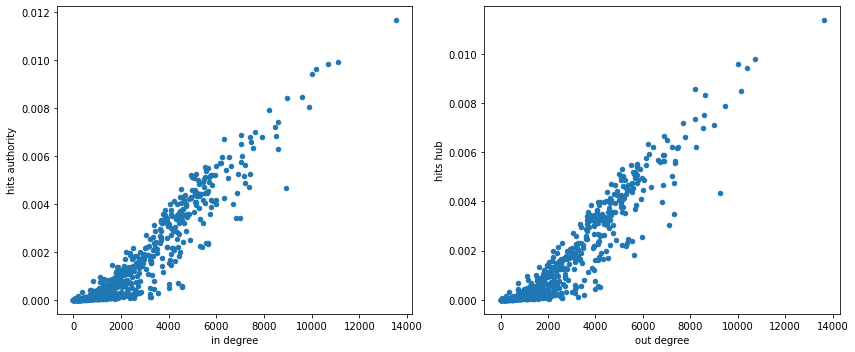

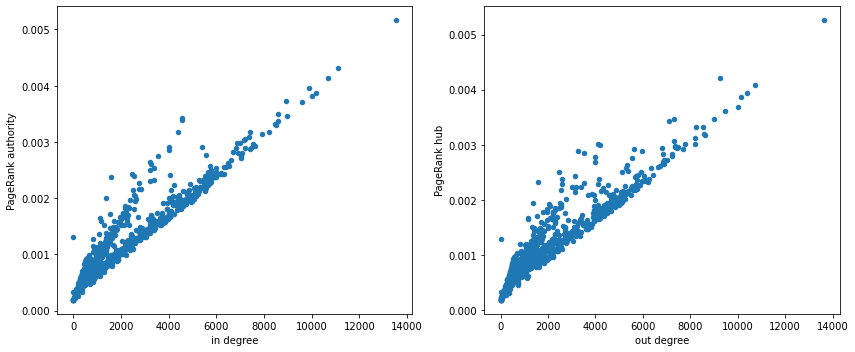

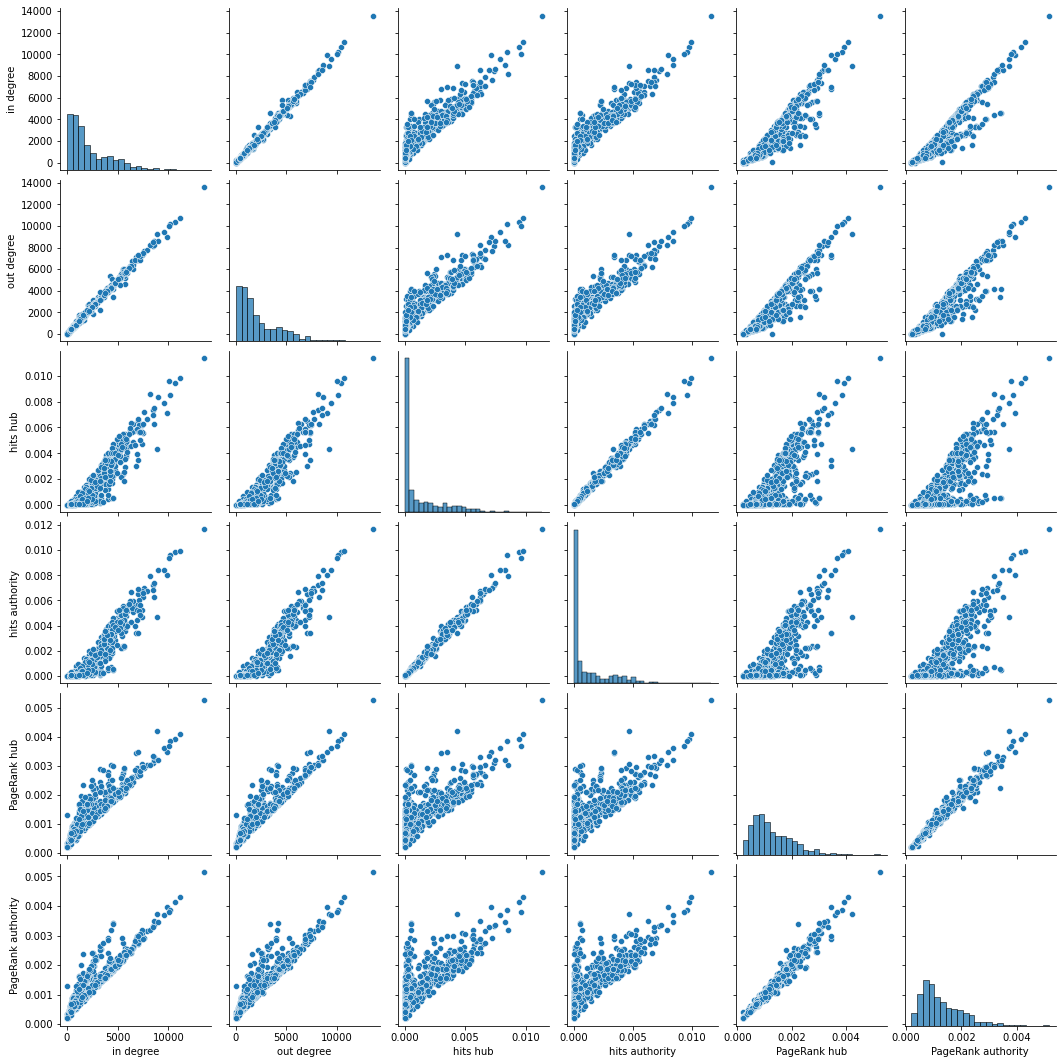

Nodes  in degree  in degree position  hits authority  \
155  Pershing Square North      13548                   1        0.011645   
400     Broadway & E 22 St      11117                   2        0.009920   
154     E 17 St & Broadway      10671                   3        0.009812   
471  West St & Chambers St       9904                   6        0.008041   
520        8 Ave & W 31 St      10194                   4        0.009624   
606        W 21 St & 6 Ave      10025                   5        0.009396   
128     Broadway & W 60 St       8926                   9        0.004678   
480     Broadway & E 14 St       9594                   7        0.008441   
202       12 Ave & W 40 St       8568                  11        0.006304   
393       W 20 St & 11 Ave       8967                   8        0.008402   

     hits authority position  PageRank authority  PageRank authority position  
155                        1            0.005162                            1  
400                        2            0.004307                            2  
154                        3            0.004145                            3  
471                        8            0.003951                            4  
520                        4            0.003875                            5  
606                        5            0.003808                            6  
128                       58            0.003722                            7  
480                        6            0.003710                            8  
202                       21            0.003490                            9  
393                        7            0.003460                           10

Nodes  out degree  out degree position  \
155              Pershing Square North       13625                    1   
128                 Broadway & W 60 St        9248                    7   
400                 Broadway & E 22 St       10714                    2   
154                 E 17 St & Broadway       10411                    3   
520                    8 Ave & W 31 St       10141                    4   
606                    W 21 St & 6 Ave       10009                    5   
480                 Broadway & E 14 St        9450                    6   
471              West St & Chambers St        8996                    8   
756  Grand Army Plaza & Central Park S        7333                   21   
359             Central Park S & 6 Ave        7083                   25   

     hits hub  hits hub position  PageRank hub  PageRank hub position  
155  0.011365                  1      0.005257                      1  
128  0.004357                 75      0.004214                      2  
400  0.009807                  2      0.004091                      3  
154  0.009427                  4      0.003941                      4  
520  0.008478                  6      0.003872                      5  
606  0.009586                  3      0.003681                      6  
480  0.007874                  8      0.003612                      7  
471  0.007117                 12      0.003463                      8  
756  0.003497                112      0.003462                      9  
359  0.003033                142      0.003437                     10

In [14]:
NY_scores = hits_pagerank(NY_adj, NY_nodes_df, NY_scores)

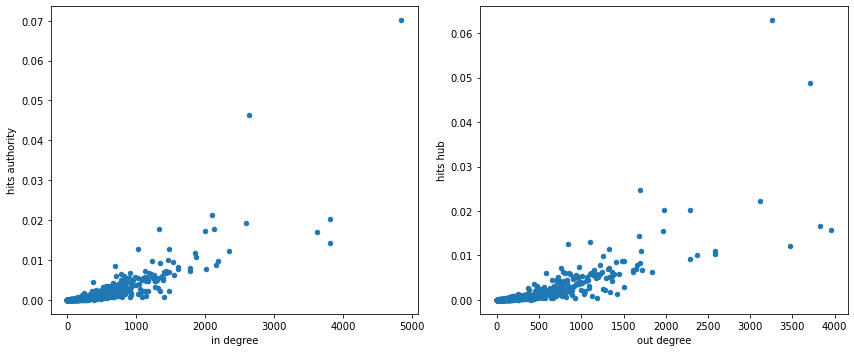

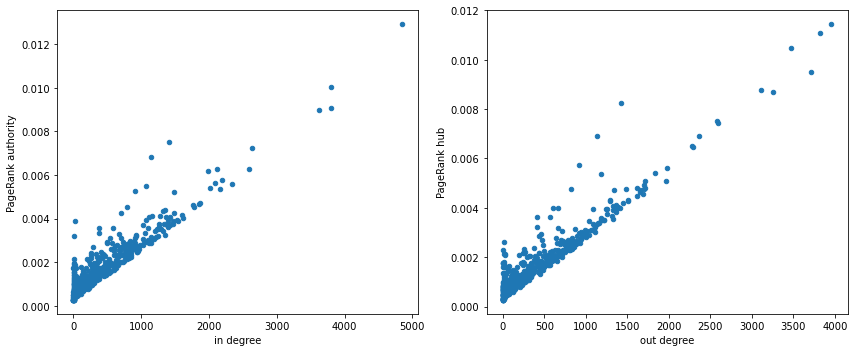

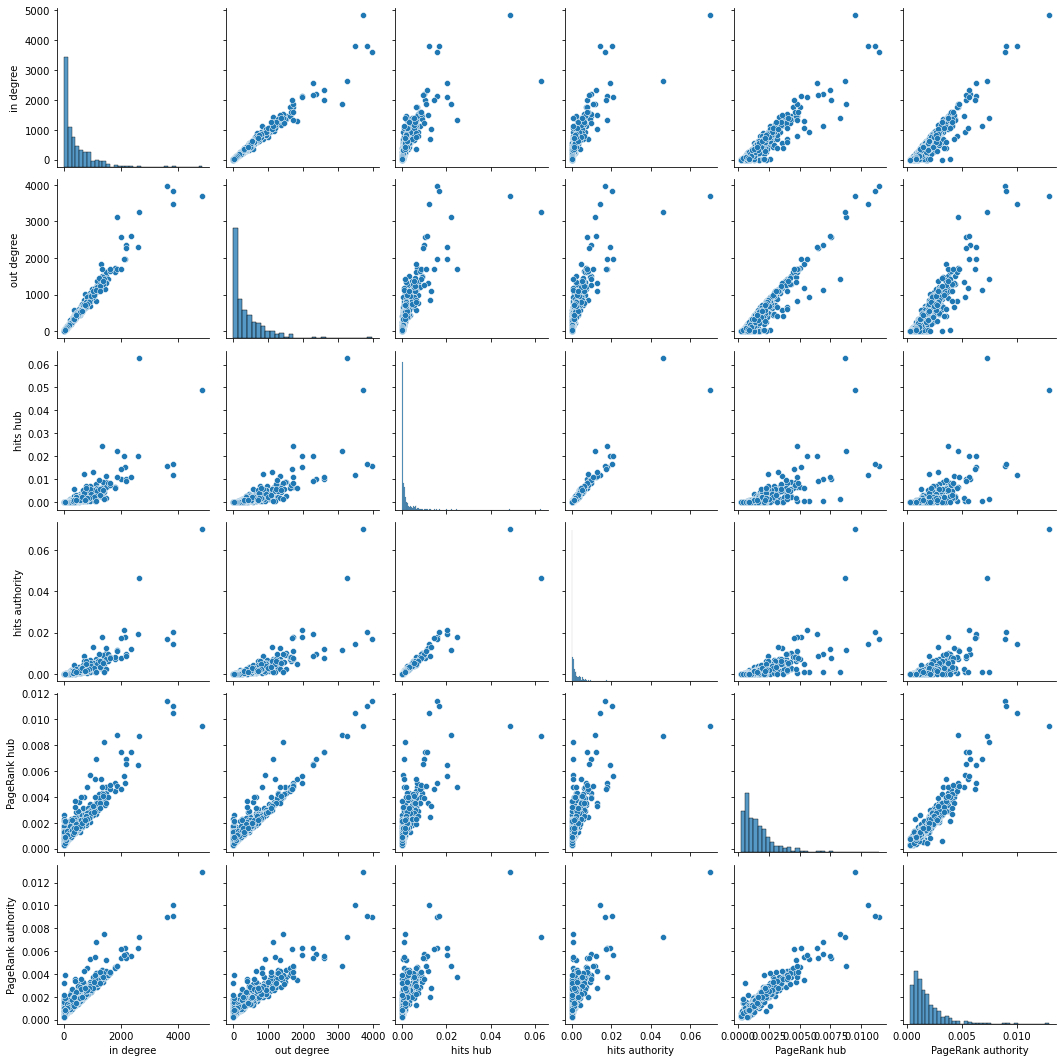

Nodes  in degree  in degree position  \
409       Streeter Dr & Grand Ave       4844                   1   
282       Clinton St & Madison St       3804                   3   
334           Canal St & Adams St       3806                   2   
180  Clinton St & Washington Blvd       3619                   4   
297           Ellis Ave & 55th St       1406                  28   
376     Lake Shore Dr & Monroe St       2630                   5   
538      University Ave & 57th St       1138                  52   
277  Michigan Ave & Washington St       2584                   6   
121         Michigan Ave & Oak St       2126                  10   
507           Theater on the Lake       1990                  13   

     hits authority  hits authority position  PageRank authority  \
409        0.070094                        1            0.012933   
282        0.014311                       10            0.010049   
334        0.020328                        4            0.009070   
180        0.017008                        9            0.008976   
297        0.000676                      230            0.007507   
376        0.046260                        2            0.007258   
538        0.000929                      202            0.006818   
277        0.019395                        5            0.006295   
121        0.017662                        7            0.006267   
507        0.017344                        8            0.006200   

     PageRank authority position  
409                            1  
282                            2  
334                            3  
180                            4  
297                            5  
376                            6  
538                            7  
277                            8  
121                            9  
507                           10

Nodes  out degree  out degree position  hits hub  \
180  Clinton St & Washington Blvd        3958                    1  0.015735   
334           Canal St & Adams St        3827                    2  0.016651   
282       Clinton St & Madison St        3477                    4  0.012114   
409       Streeter Dr & Grand Ave        3710                    3  0.048865   
11      Columbus Dr & Randolph St        3112                    6  0.022274   
376     Lake Shore Dr & Monroe St        3253                    5  0.062892   
297           Ellis Ave & 55th St        1426                   28  0.001418   
59        Franklin St & Monroe St        2585                    8  0.010269   
202         Canal St & Madison St        2589                    7  0.011080   
122            Daley Center Plaza        2366                    9  0.010037   

     hits hub position  PageRank hub  PageRank hub position  
180                  8      0.011449                      1  
334                  7      0.011069                      2  
282                 13      0.010497                      3  
409                  2      0.009492                      4  
11                   4      0.008772                      5  
376                  1      0.008710                      6  
297                153      0.008251                      7  
59                  17      0.007509                      8  
202                 15      0.007458                      9  
122                 18      0.006909                     10

In [15]:
CHI_scores = hits_pagerank(CHI_adj, CHI_nodes_df, CHI_scores)

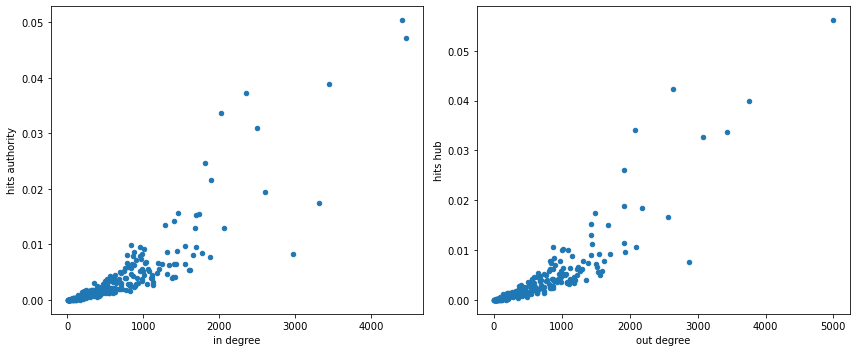

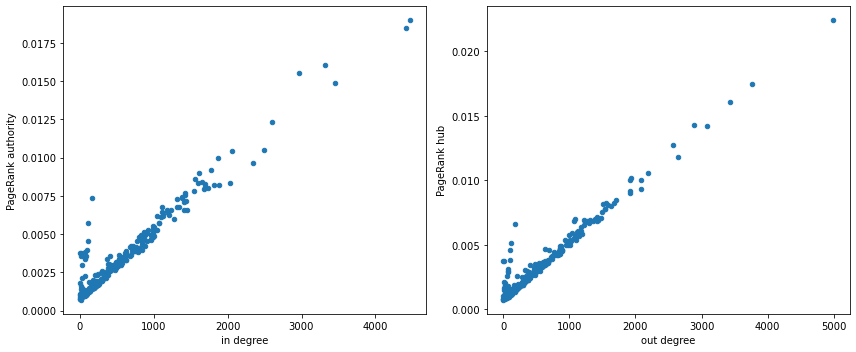

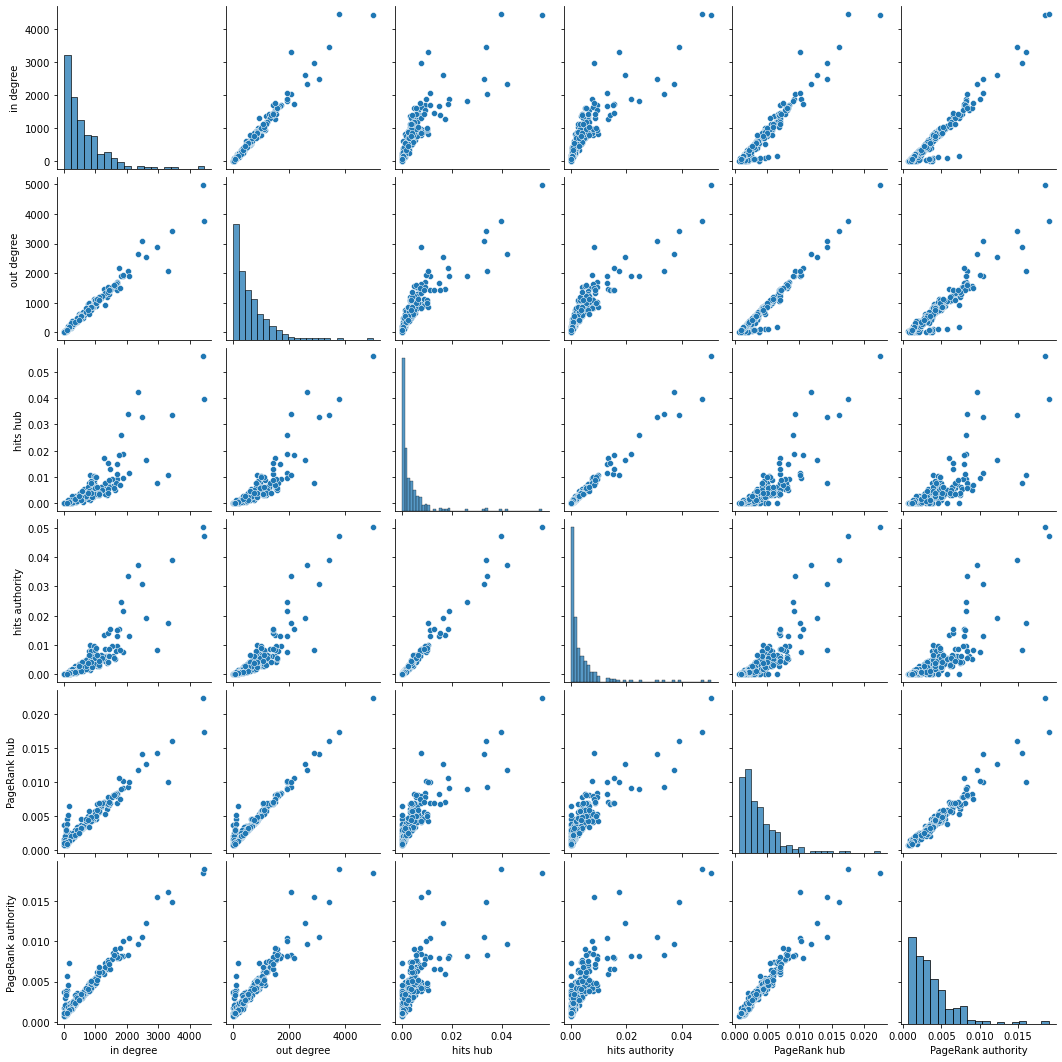

Nodes  in degree  \
102            MIT Stata Center at Vassar St / Main St       4463   
66                        MIT at Mass Ave / Amherst St       4412   
227                  Nashua Street at Red Auerbach Way       3313   
178                   South Station - 700 Atlantic Ave       2968   
105              Central Square at Mass Ave / Essex St       3449   
57                 Harvard Square at Mass Ave/ Dunster       2603   
160                                          Kendall T       2499   
147  Christian Science Plaza - Massachusetts Ave at...       2060   
150        Back Bay T Stop - Dartmouth St at Stuart St       1876   
242                    MIT Pacific St at Purrington St       2348   

     in degree position  hits authority  hits authority position  \
102                   1        0.047109                        2   
66                    2        0.050342                        1   
227                   4        0.017508                       10   
178                   5        0.008236                       27   
105                   3        0.038942                        3   
57                    6        0.019369                        9   
160                   7        0.030870                        6   
147                   9        0.013011                       16   
150                  12        0.007679                       33   
242                   8        0.037247                        4   

     PageRank authority  PageRank authority position  
102            0.018972                            1  
66             0.018503                            2  
227            0.016048                            3  
178            0.015538                            4  
105            0.014849                            5  
57             0.012296                            6  
160            0.010476                            7  
147            0.010429                            8  
150            0.009999                            9  
242            0.009626                           10

Nodes  out degree  \
66                       MIT at Mass Ave / Amherst St        4989   
102           MIT Stata Center at Vassar St / Main St        3761   
105             Central Square at Mass Ave / Essex St        3435   
178                  South Station - 700 Atlantic Ave        2879   
160                                         Kendall T        3075   
57                Harvard Square at Mass Ave/ Dunster        2563   
242                   MIT Pacific St at Purrington St        2644   
157  One Kendall Square at Hampshire St / Portland St        2186   
150       Back Bay T Stop - Dartmouth St at Stuart St        1934   
227                 Nashua Street at Red Auerbach Way        2086   

     out degree position  hits hub  hits hub position  PageRank hub  \
66                     1  0.056120                  1      0.022396   
102                    2  0.039828                  3      0.017426   
105                    3  0.033792                  5      0.016085   
178                    5  0.007659                 33      0.014313   
160                    4  0.032754                  6      0.014221   
57                     7  0.016678                 11      0.012740   
242                    6  0.042249                  2      0.011792   
157                    8  0.018485                  9      0.010596   
150                   11  0.009655                 22      0.010194   
227                    9  0.010621                 17      0.010044   

     PageRank hub position  
66                       1  
102                      2  
105                      3  
178                      4  
160                      5  
57                       6  
242                      7  
157                      8  
150                      9  
227                     10

In [16]:
BOS_scores = hits_pagerank(BOS_adj, BOS_nodes_df, BOS_scores)

### Assortativity

In [17]:
# tuple containing the slopes of assortativity plots
def assortativity_calc(edges, adj, nodes):
    edges.drop_duplicates(inplace=True)
    n = degree_distribution(adj, nodes)
    n.rename({'Nodes': 'source','in degree': 'source in degree', 'out degree': 'source out degree'},axis=1, inplace=True)
    cross_df = pd.merge(edges, n, on="source")
    n.rename({'source': 'target','source in degree': 'target in degree', 'source out degree': 'target out degree'},axis=1, inplace=True)
    cross_df = pd.merge(cross_df, n, on="target")
    in_neigh = cross_df[['source', 'target in degree', 'target out degree']].groupby('source', as_index=False).mean()
    out_neigh = cross_df[['target', 'source in degree', 'source out degree']].groupby('target', as_index=False).mean()
    in_neigh.rename({'source':'Nodes', 'target in degree': 'Average target in degree', 'target out degree': 'Average target out degree'},axis=1, inplace=True)
    out_neigh.rename({'target':'Nodes', 'source in degree': 'Average source in degree', 'source out degree': 'Average source out degree'},axis=1, inplace=True)
    n.rename({'target': 'Nodes','target in degree': 'in degree', 'target out degree': 'out degree'},axis=1, inplace=True)
    cross_df = pd.merge(n, in_neigh, on="Nodes", how='left')
    cross_df = pd.merge(cross_df, out_neigh, on="Nodes", how='left')
    cross_df.fillna(0, inplace=True)
    x = ['out degree','out degree','in degree','in degree']
    y = ['Average target in degree', 'Average target out degree', 'Average source in degree', 'Average source out degree']
    
    fig, ax = plt.subplots(2,2,figsize=(18,15))
    
    # computing assortativity coefficient
    def calc_mu(cross_df, x, y, ax=None):
        means = cross_df[[x,y]].groupby(x, as_index=False).mean()
        means[means==0] = np.nan
        means.dropna(inplace=True)
        means['log '+x] = np.log10(means[x])
        means['log '+y] = np.log10(means[y])
        interpolation = stats.linregress(means['log '+x], means['log '+y])
        
        inter_x = np.logspace(0, max(means['log '+x]),1000)
        inter_y = inter_x**(interpolation.slope)*10**(interpolation.intercept)

        ax.loglog(cross_df[x], cross_df[y], 'o', markersize=3)
        ax.loglog(means[x], means[y], 'o', markersize=3)
        ax.plot(inter_x,inter_y,linewidth=3)
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        return interpolation.slope
        
    ax = ax.reshape(4)
    mu = ()
    for e_x, e_y, e_ax in zip(x, y, ax):
        e_mu = calc_mu(cross_df, e_x, e_y, e_ax)
        mu += (e_mu, )
    plt.show()
    return mu

In [18]:
def assortativity(df, adj_matrix, nodes_df, scores, nodes):
    df.rename({'start station name': 'source','end station name': 'target'},axis=1, inplace=True)
    edges = df[['source','target']].copy()
    print(assortativity_calc(edges, adj_matrix, nodes_df))
    
    # new adjacency matrix visualization
    label = 'in degree position'
    c = df.drop(['SendId', 'RecId'],axis=1)
    another_order = scores[['Nodes', label]].copy()
    another_order[label] = another_order[label] - 1
    another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="source")
    another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="target")
    c = c[['source ID', 'target ID', 'tripduration']]
    c_serie = c.groupby(['source ID', 'target ID']).count()
    row = np.array(c_serie.index.get_level_values(1).tolist())
    col = np.array(c_serie.index.get_level_values(0).tolist())
    val = c_serie.values
    or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    visualize_adj(or_adj)
    matr = or_adj.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()

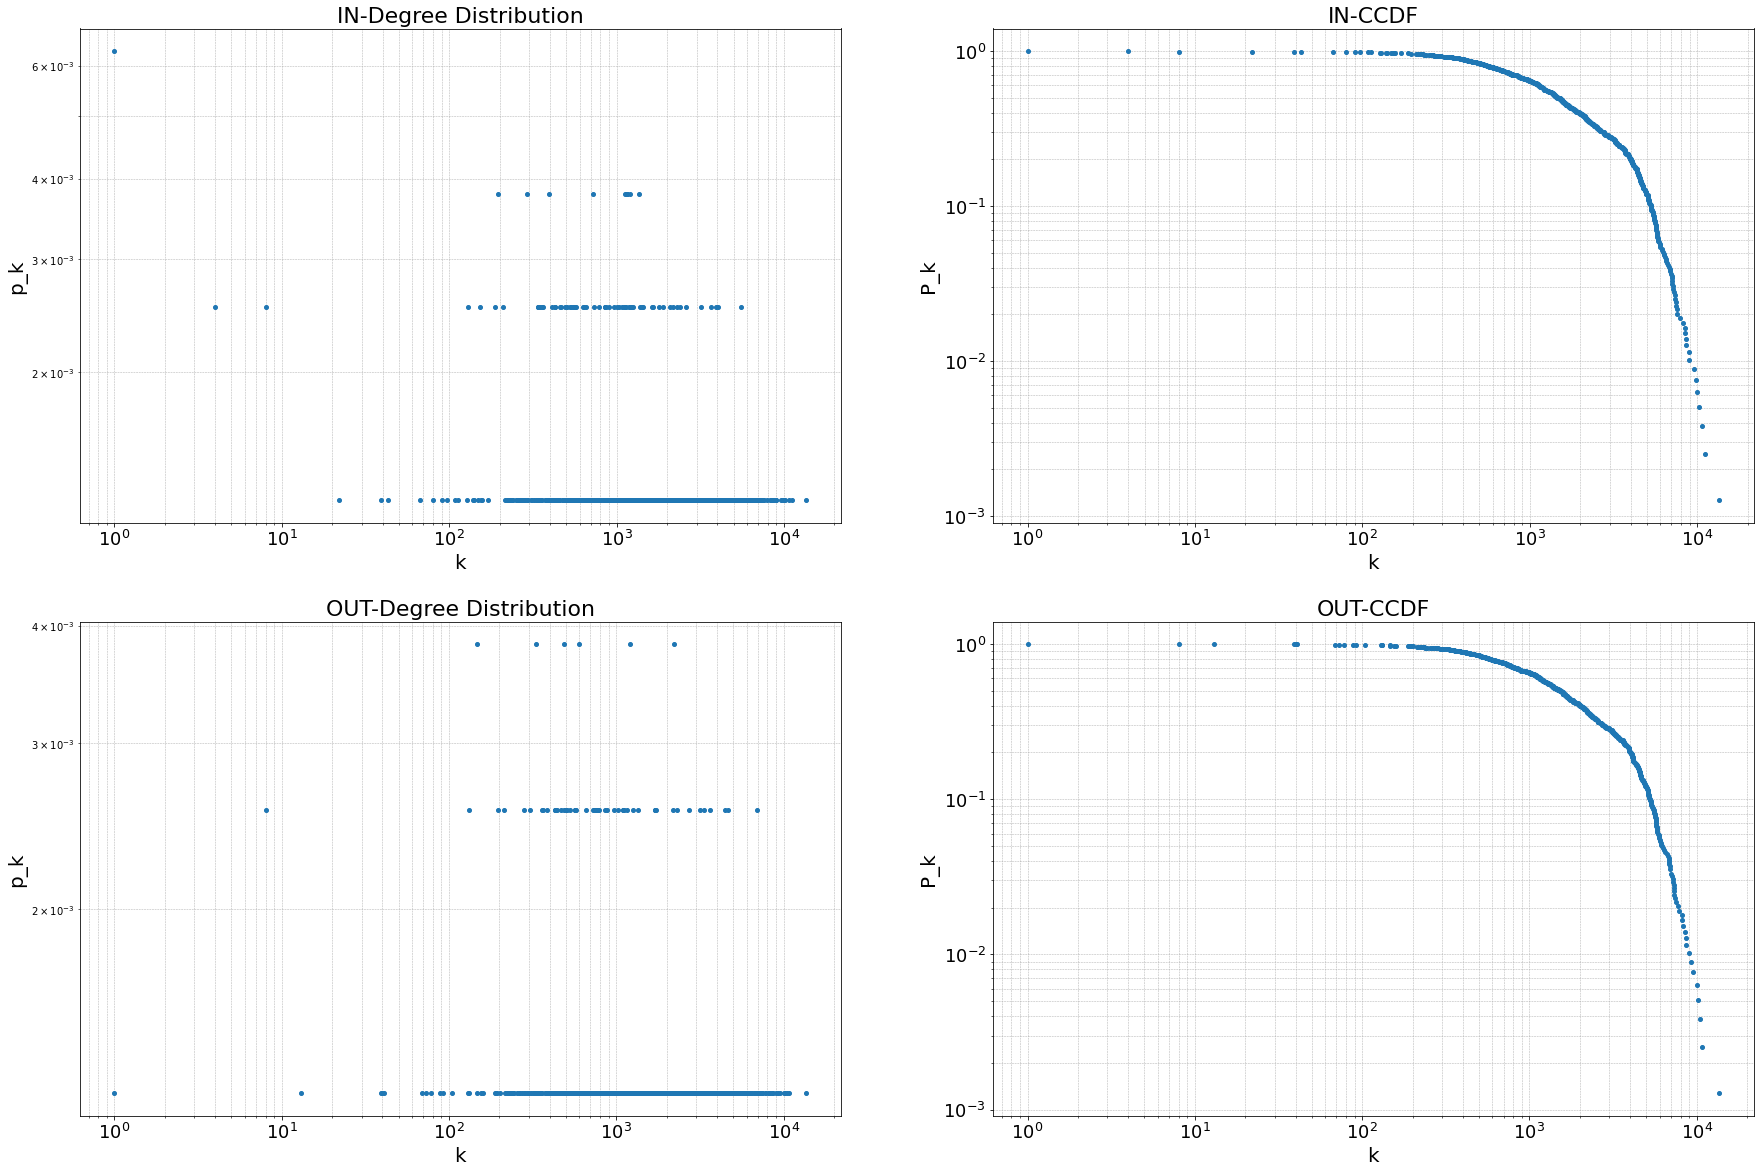

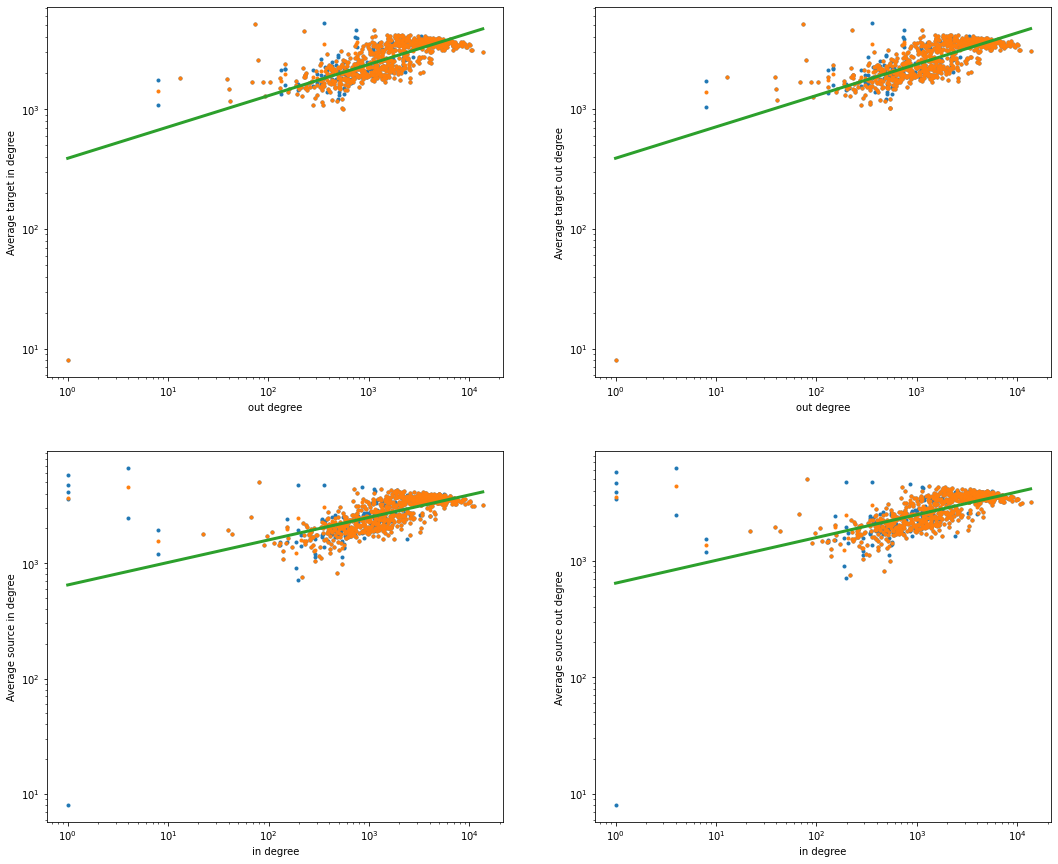

(0.2614005417482248, 0.26142234669798514, 0.19509859927195414, 0.19583699776444377)


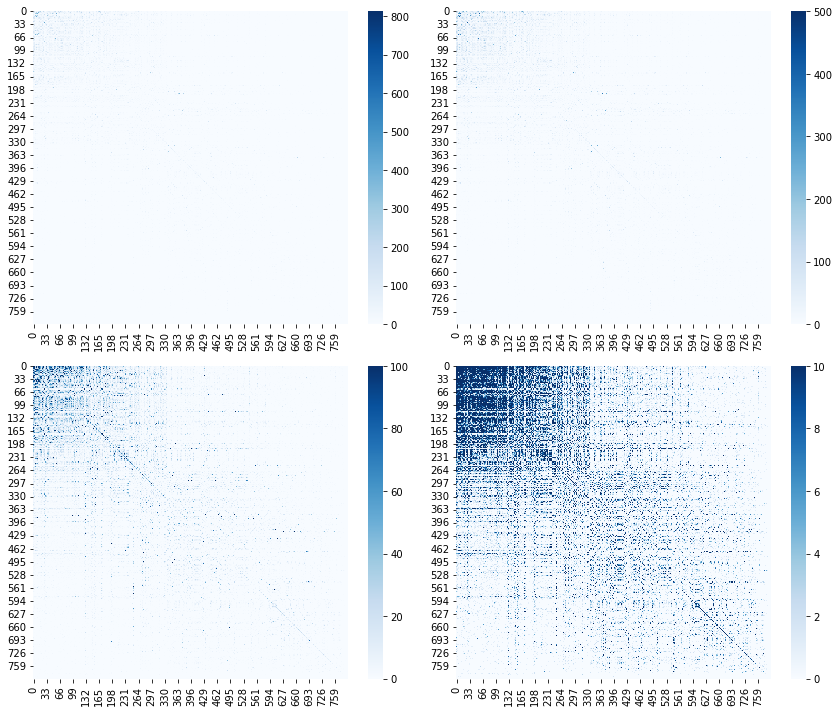

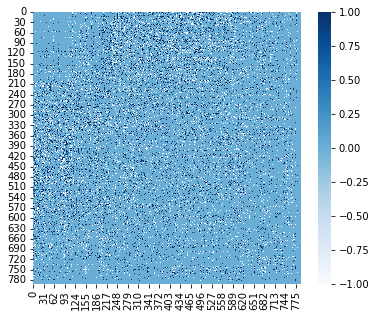

In [19]:
assortativity(NY_df, NY_adj, NY_nodes_df, NY_scores, NY_nodes)

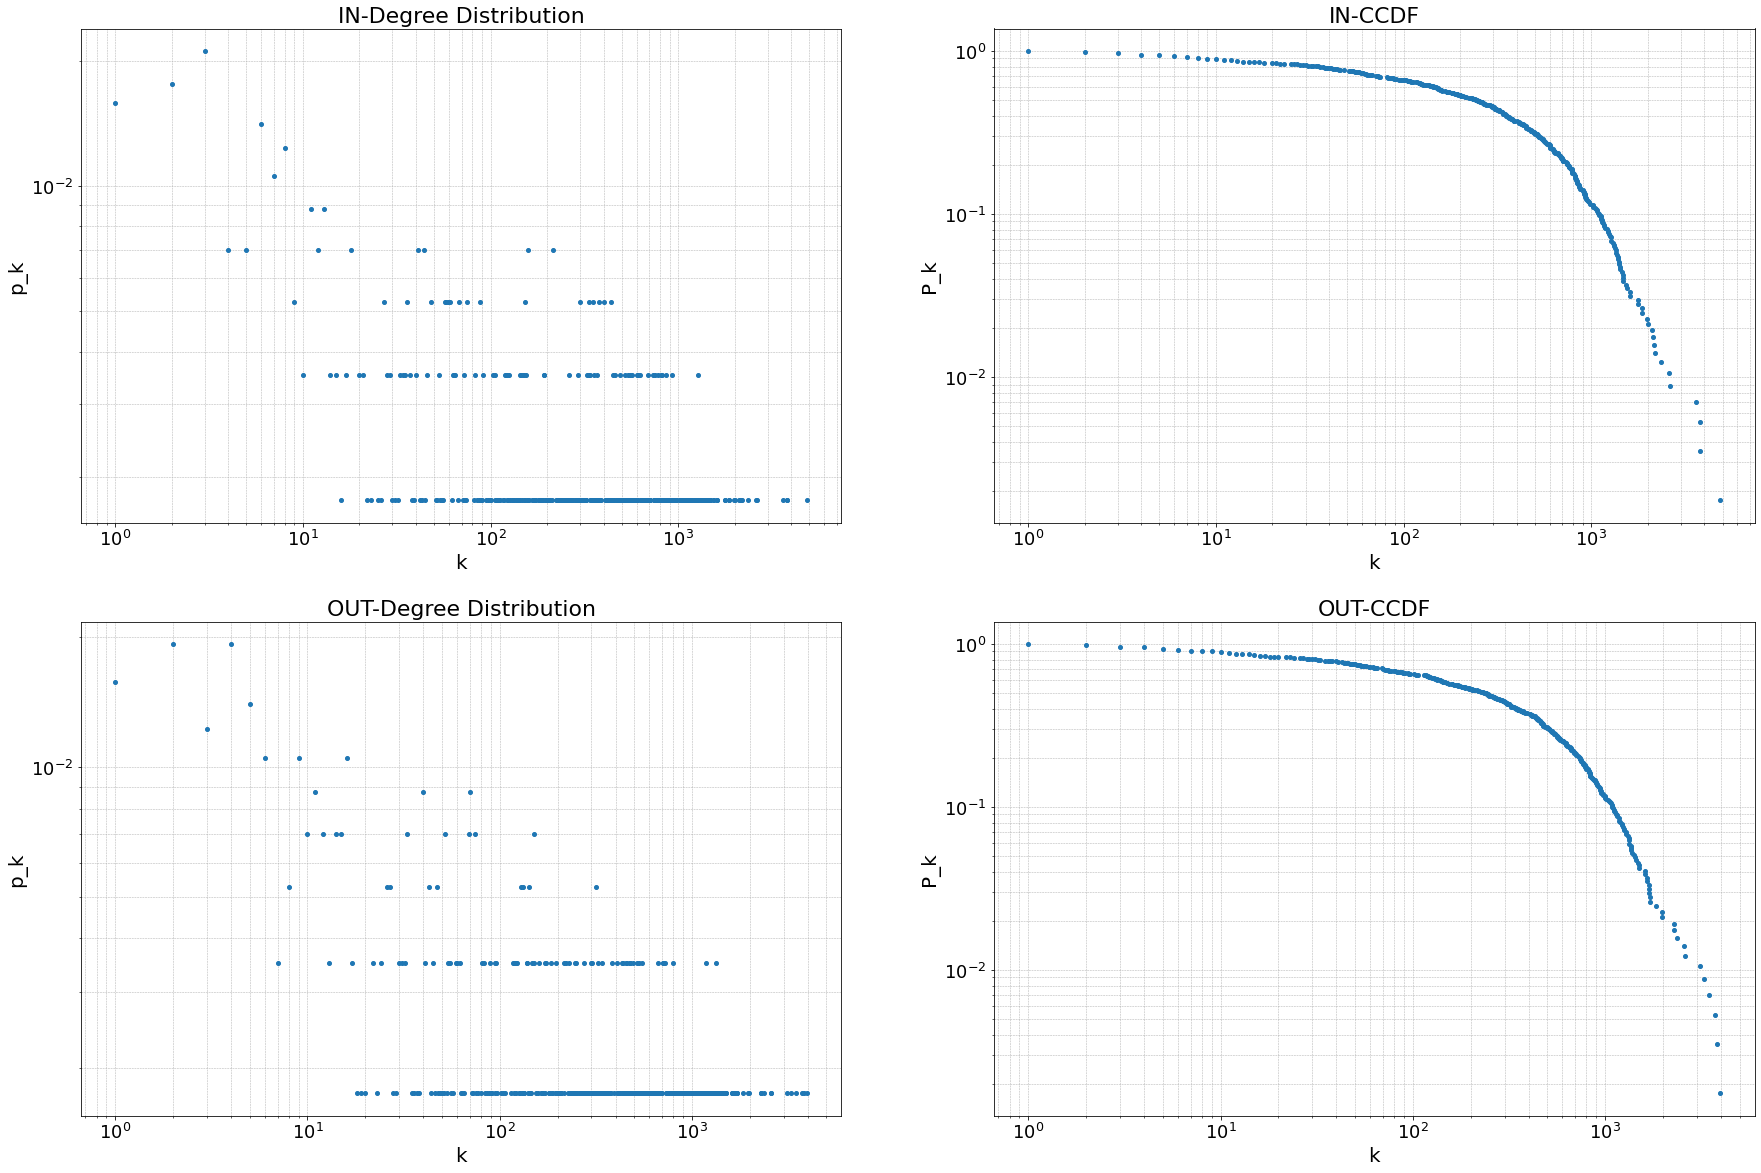

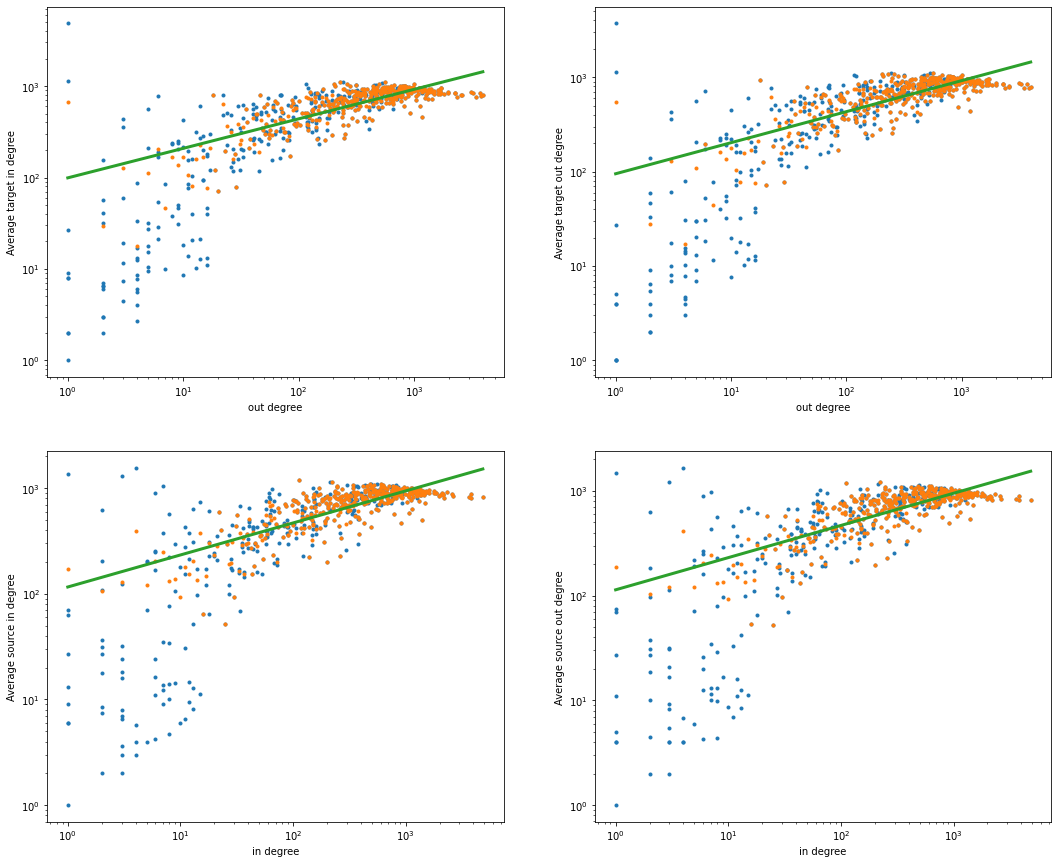

(0.3225183599091545, 0.32895812905677524, 0.30307079701727063, 0.30712139666824495)


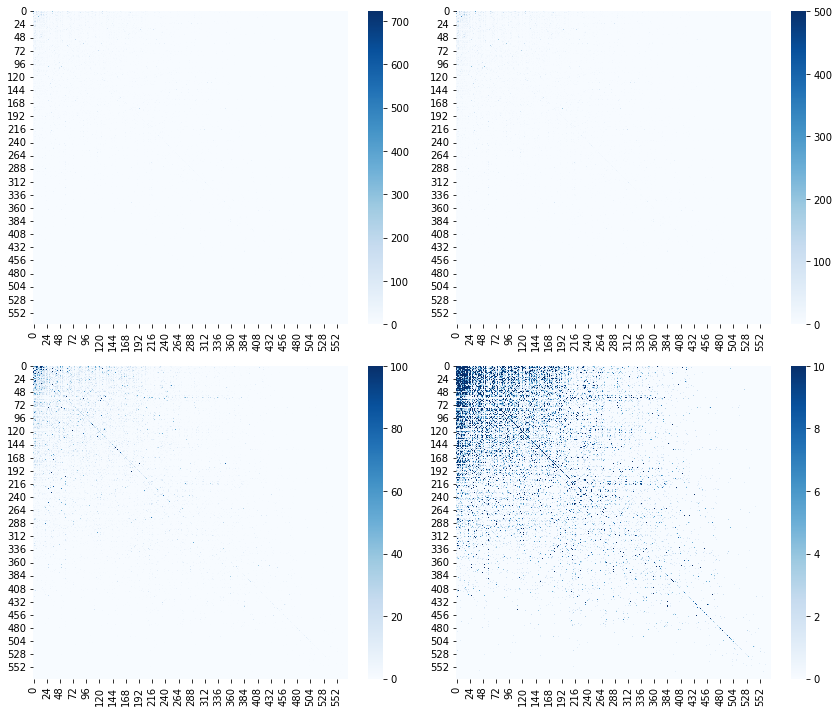

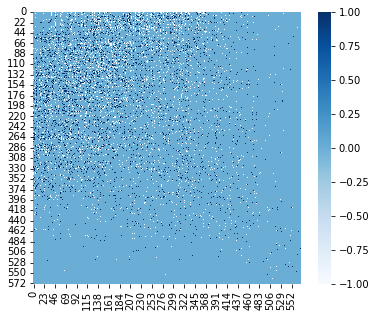

In [20]:
assortativity(CHI_df, CHI_adj, CHI_nodes_df, CHI_scores, CHI_nodes)

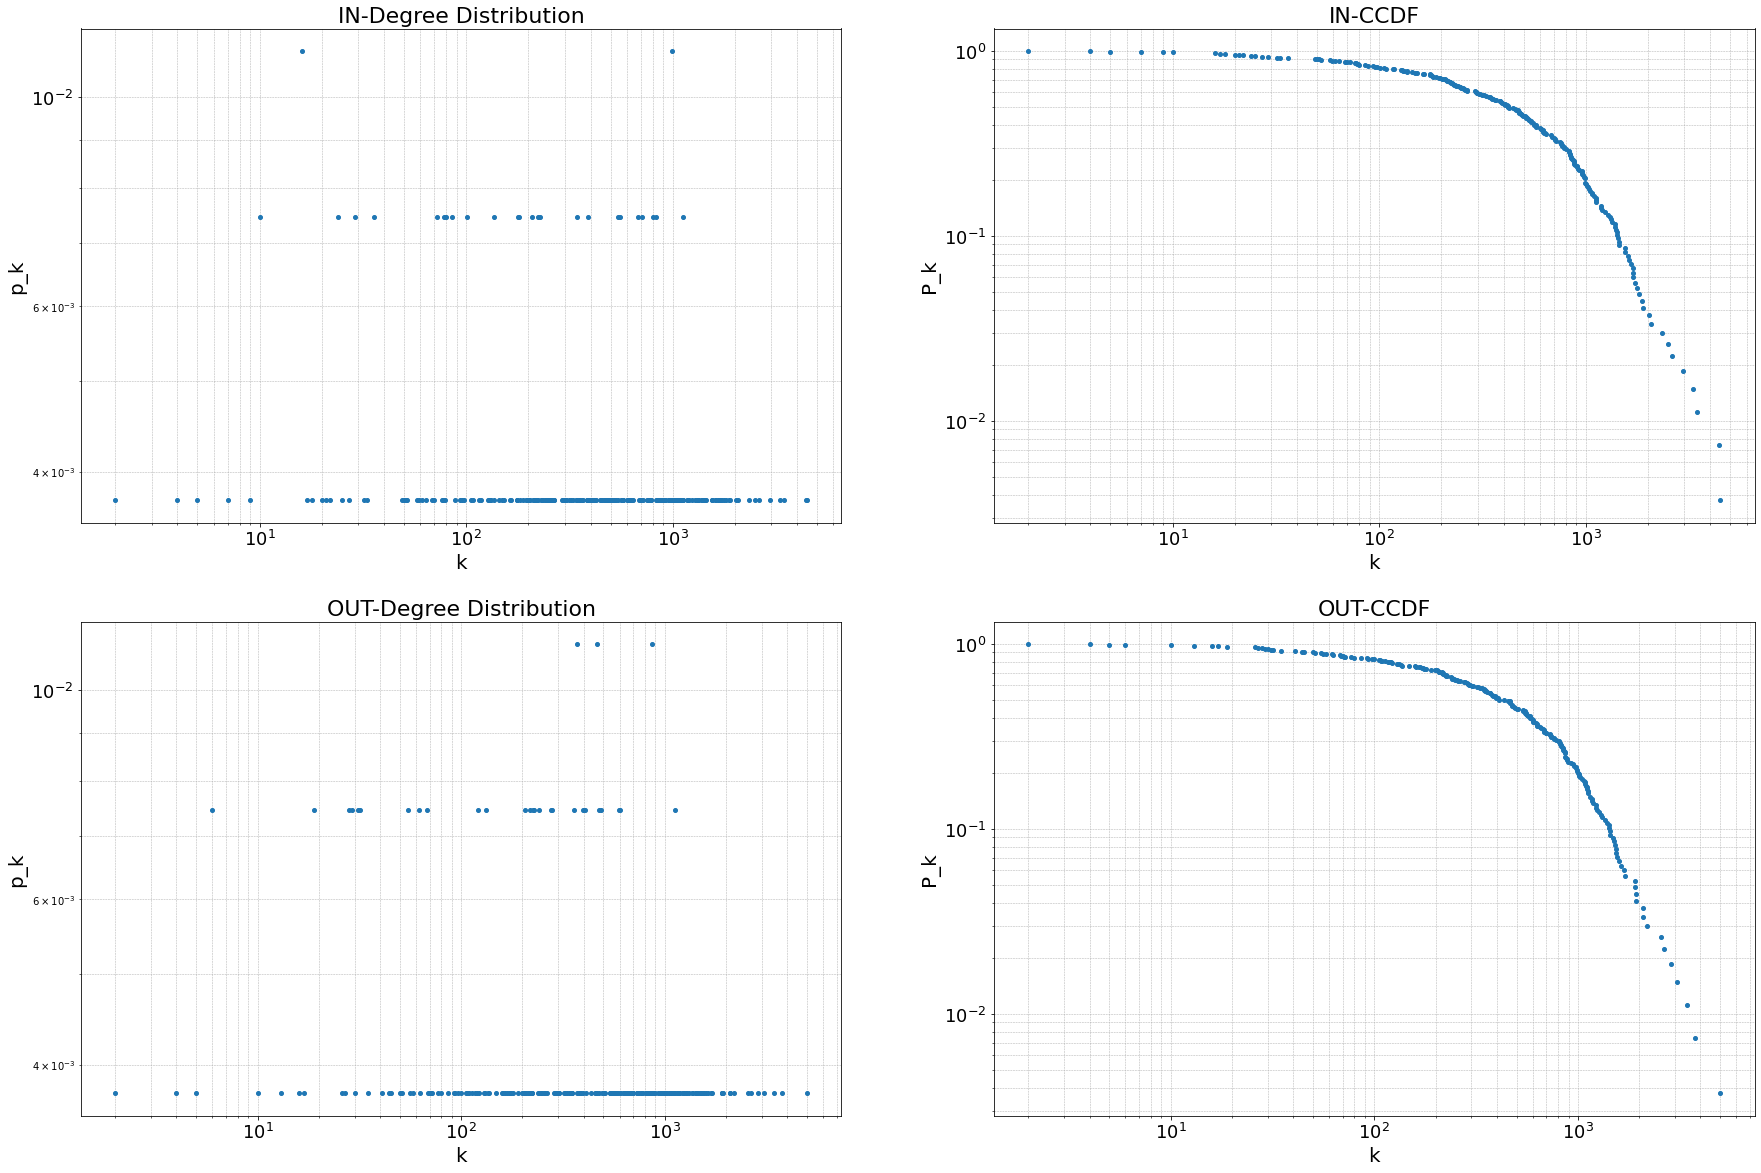

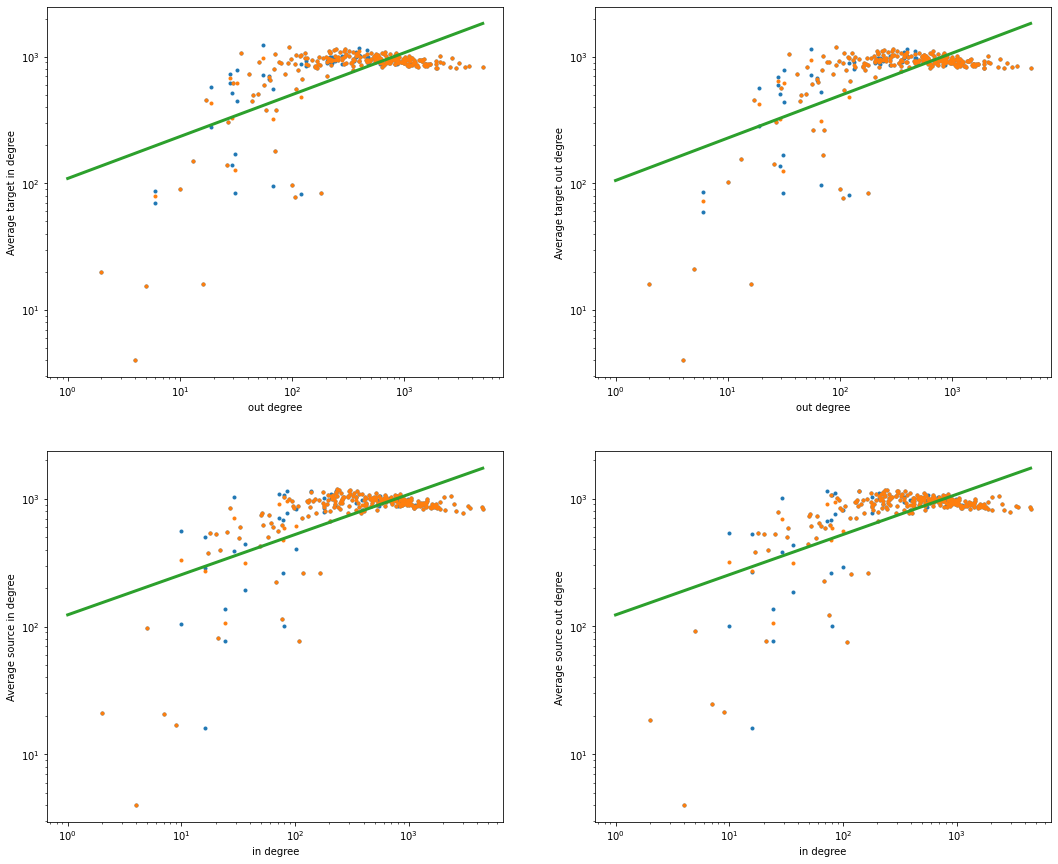

(0.33097912035532717, 0.3353647288486523, 0.3144171886391234, 0.31443070480072416)


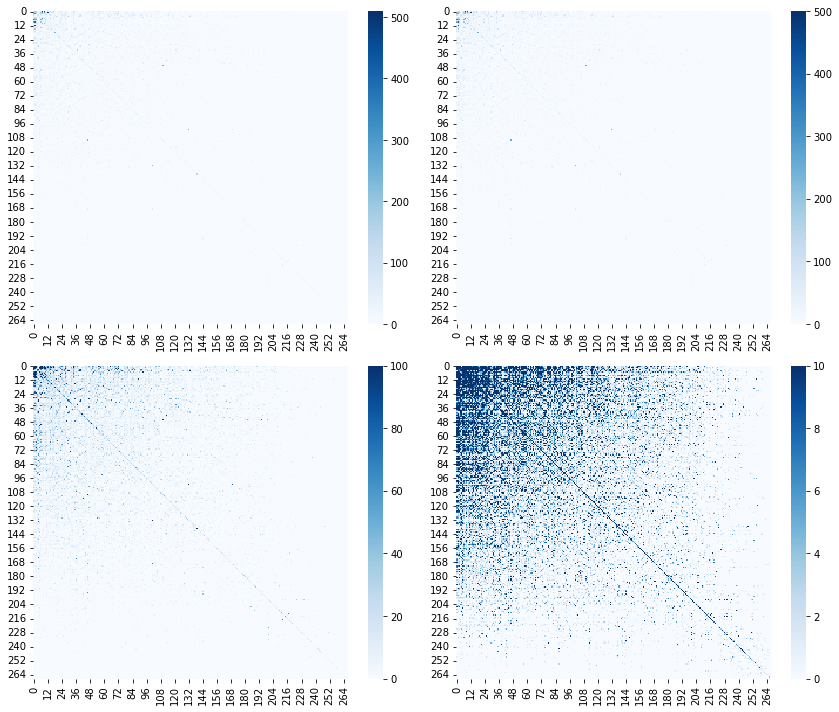

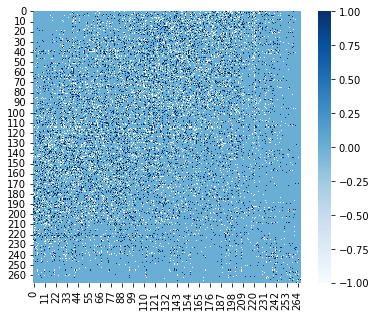

In [21]:
assortativity(BOS_df, BOS_adj, BOS_nodes_df, BOS_scores, BOS_nodes)